In [1]:
# Download AFAD dataset
import os
import tarfile

dataset_tar = 'afad.tar.xz'
dataset_folder = 'AFAD-Full'

if dataset_folder not in os.listdir():
    !git clone https://github.com/John-niu-07/tarball.git
    !cat tarball/AFAD-Full.tar.xz* > {dataset_tar}
    !rm -rfv tarball
    !tar -xf {dataset_tar}
    !rm {dataset_tar}


# Dataset labelling
from tqdm import tqdm

afad_filenames = []
afad_ages = []

for age in tqdm(os.listdir(dataset_folder)):
    if not age.isdigit():
        continue
    
    sub_folders = os.listdir(
        os.path.join(
            dataset_folder, age
        )
    )
    
    for sf in sub_folders:
        cur_folder = os.path.join(
            dataset_folder, age, sf
        )
        for file in os.listdir(cur_folder):
            if not file.endswith('.jpg'):
                continue
                
            afad_filenames.append(
                os.path.join(
                    cur_folder, file
                )
            )
            afad_ages.append(int(age))


# Create pandas dataframe
import pandas as pd

afad_dataframe = pd.DataFrame(
    {
    'image_path': afad_filenames,
    'age': afad_ages
    }
)

def convert_label(age):
    return 1 if int(age) >= 18 else 0

afad_dataframe['label'] = afad_dataframe['age'].apply(convert_label)

print(afad_dataframe['label'].value_counts())
afad_dataframe



Cloning into 'tarball'...
remote: Enumerating objects: 55, done.
remote: Total 55 (delta 0), reused 0 (delta 0), pack-reused 55 (from 1)
Receiving objects: 100% (55/55), 1.43 GiB | 52.81 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (48/48), done.
removed 'tarball/AFAD-Full.tar.xzaz'
removed 'tarball/AFAD-Full.tar.xzbp'
removed 'tarball/AFAD-Full.tar.xzac'
removed 'tarball/AFAD-Full.tar.xzag'
removed 'tarball/AFAD-Full.tar.xzaq'
removed 'tarball/AFAD-Full.tar.xzav'
removed 'tarball/AFAD-Full.tar.xzaw'
removed 'tarball/AFAD-Full.tar.xzam'
removed 'tarball/AFAD-Full.tar.xzbo'
removed 'tarball/.git/hooks/push-to-checkout.sample'
removed 'tarball/.git/hooks/pre-receive.sample'
removed 'tarball/.git/hooks/pre-merge-commit.sample'
removed 'tarball/.git/hooks/post-update.sample'
removed 'tarball/.git/hooks/applypatch-msg.sample'
removed 'tarball/.git/hooks/pre-push.sample'
removed 'tarball/.git/hooks/update.sample'
removed 'tarball/.git/hooks/prepare-commit-msg.sample'

100%|██████████| 63/63 [00:00<00:00, 175.13it/s]


label
1    159345
0      6156
Name: count, dtype: int64


,image_path,age,label
0,AFAD-Full/25/112/77551-0.jpg,25,1
1,AFAD-Full/25/112/175389-0.jpg,25,1
2,AFAD-Full/25/112/161126-0.jpg,25,1
3,AFAD-Full/25/112/195912-0.jpg,25,1
4,AFAD-Full/25/112/85579-0.jpg,25,1
...,...,...,...
165496,AFAD-Full/50/111/856649-1.jpg,50,1
165497,AFAD-Full/50/111/856073-0.jpg,50,1
165498,AFAD-Full/50/111/855268-0.jpg,50,1
165499,AFAD-Full/50/111/858519-0.jpg,50,1


In [2]:
# Download UTKFace dataset (add the dataset manually through kaggle)
utkface_folder = "/kaggle/input/utkface-new"
selected_subset = 'crop_part1'

utkface_path = os.path.join(utkface_folder, selected_subset)

utk_filenames = []
utk_ages = []
for utkfile in os.listdir(utkface_path):
    if not utkfile.endswith('.jpg'):
        continue
    
    file_info = utkfile[:-13] # Remove extension (.jpg.chip.jpg)
    file_info = file_info.split('_')
    race_id = file_info[2]
    if int(race_id) == 2: # race id for Asian
        utk_filenames.append(
            os.path.join(
                utkface_path, utkfile
            )            
        )
        utk_ages.append(
            int(file_info[0])
        )
        
utkface_dataframe = pd.DataFrame(
    {
    'image_path': utk_filenames,
    'age': utk_ages
    }
)

utkface_dataframe['label'] = utkface_dataframe['age'].apply(convert_label)

print(utkface_dataframe['label'].value_counts())
utkface_dataframe


label
0    978
1    575
Name: count, dtype: int64


,image_path,age,label
0,/kaggle/input/utkface-new/crop_part1/26_0_2_20...,26,1
1,/kaggle/input/utkface-new/crop_part1/26_1_2_20...,26,1
2,/kaggle/input/utkface-new/crop_part1/90_0_2_20...,90,1
3,/kaggle/input/utkface-new/crop_part1/1_0_2_201...,1,0
4,/kaggle/input/utkface-new/crop_part1/1_1_2_201...,1,0
...,...,...,...
1548,/kaggle/input/utkface-new/crop_part1/1_0_2_201...,1,0
1549,/kaggle/input/utkface-new/crop_part1/57_1_2_20...,57,1
1550,/kaggle/input/utkface-new/crop_part1/38_1_2_20...,38,1
1551,/kaggle/input/utkface-new/crop_part1/3_0_2_201...,3,0


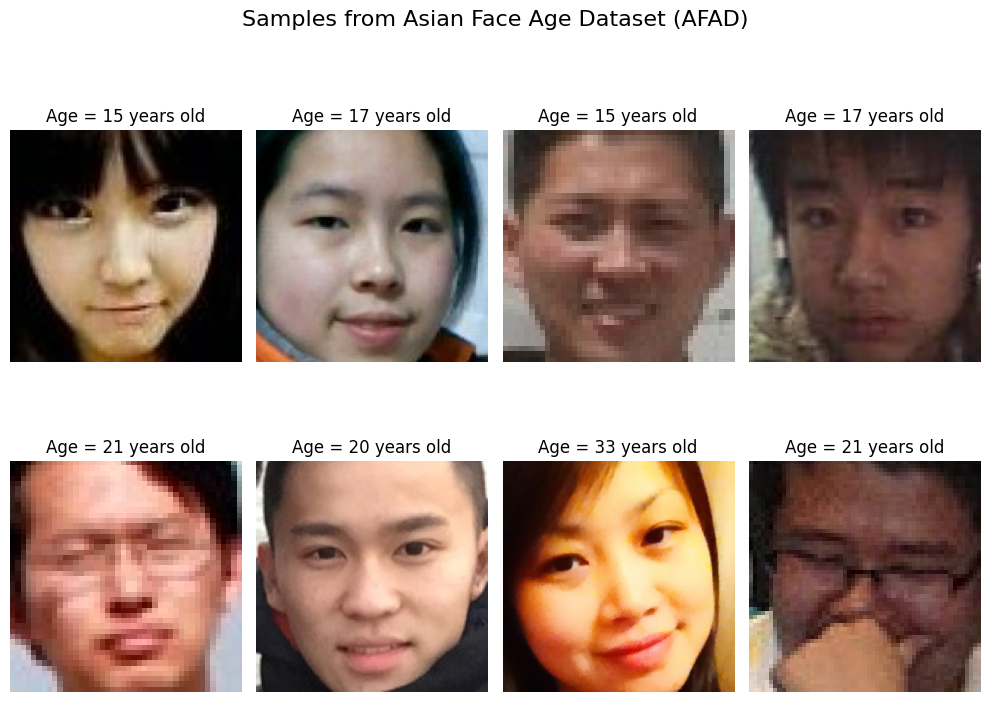

In [3]:
# Show image samples

import matplotlib.pyplot as plt
from PIL import Image

total_images_to_show = 4

# Display samples from AFAD dataset
afad_young_sample = afad_dataframe[afad_dataframe['age'] < 18].sample(n=total_images_to_show)
afad_old_sample = afad_dataframe[afad_dataframe['age'] > 18].sample(n=total_images_to_show)
afad_samples = pd.concat([afad_young_sample, afad_old_sample], ignore_index=True)

# Define grid size
rows, cols = 2, total_images_to_show

fig_afad, axes_afad = plt.subplots(rows, cols, figsize=(10, 8))
axes_afad = axes_afad.ravel()

for i, ax in enumerate(axes_afad):
    ax.imshow(Image.open(afad_samples.iloc[i].image_path))
    ax.set_title(f"Age = {afad_samples.iloc[i].age} years old")
    ax.axis("off")

fig_afad.suptitle('Samples from Asian Face Age Dataset (AFAD)', fontsize=16)
plt.tight_layout()
plt.savefig("/kaggle/working/samples_afad.png", dpi=300, bbox_inches="tight")
plt.show()

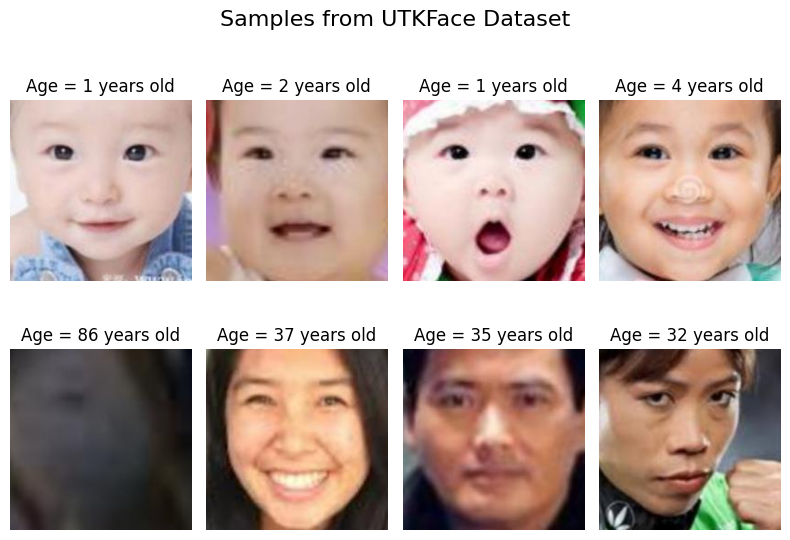

In [4]:
# Display samples from UTKFace dataset
utkface_young_sample = utkface_dataframe[utkface_dataframe['age'] < 18].sample(n=total_images_to_show)
utkface_old_sample = utkface_dataframe[utkface_dataframe['age'] > 18].sample(n=total_images_to_show)
utkface_samples = pd.concat([utkface_young_sample, utkface_old_sample], ignore_index=True)

# Define grid size
rows, cols = 2, total_images_to_show

fig_utkface, axes_utkface = plt.subplots(rows, cols, figsize=(8, 6))
axes_utkface = axes_utkface.ravel()

for i, ax in enumerate(axes_utkface):
    ax.imshow(Image.open(utkface_samples.iloc[i].image_path))
    ax.set_title(f"Age = {utkface_samples.iloc[i].age} years old")
    ax.axis("off")

fig_utkface.suptitle('Samples from UTKFace Dataset', fontsize=16)
plt.tight_layout()
plt.savefig("/kaggle/working/samples_utkface.png", dpi=300, bbox_inches="tight")
plt.show()

Minimum age = 1,  Mean age = 25.66,  Maximum age = 101
Total samples equal to or over 18 years old = 159920
Total samples under 18 years old = 7134


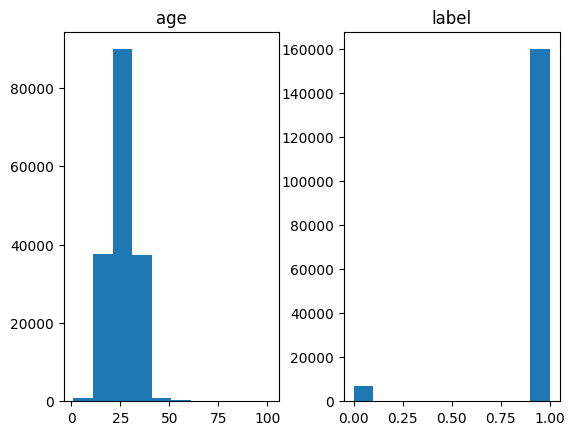

In [5]:
# Combine dataframes
combined_dataframe = pd.concat([afad_dataframe,utkface_dataframe], ignore_index=True)

# Show statistics and histograms
print(f"Minimum age = {combined_dataframe['age'].min()},  Mean age = {combined_dataframe['age'].mean():.2f},  Maximum age = {combined_dataframe['age'].max()}")
print(f"Total samples equal to or over 18 years old = {combined_dataframe['label'].value_counts().get(1)}")
print(f"Total samples under 18 years old = {combined_dataframe['label'].value_counts().get(0)}")

# Create histogram
combined_dataframe.hist(grid=False)

# Get the figure from the Axes object and save it
fig = plt.gcf()
fig.savefig("/kaggle/working/histogram_before.png", dpi=300, bbox_inches="tight")

# Show the plot (optional)
plt.show()

Minimum age = 1,  Mean age = 20.24,  Maximum age = 85
Total samples equal to or over 18 years old = 7134
Total samples under 18 years old = 7134


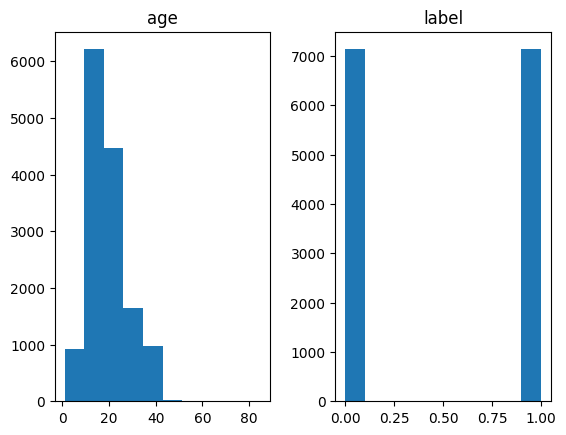

In [6]:
# Perform data resampling
target_sample = combined_dataframe['label'].value_counts().get(0) # resample based on minority class = label 0 or under 18

under18_samples = combined_dataframe[combined_dataframe['label'] == 0].sample(n=target_sample)
over18_samples = combined_dataframe[combined_dataframe['label'] == 1].sample(n=target_sample)

resampled_dataframe = pd.concat([under18_samples, over18_samples], ignore_index=True)
resampled_dataframe = resampled_dataframe.sample(frac=1).reset_index(drop=True) # Shuffle the rows, and ignore old index
resampled_dataframe

# Show statistics and histograms
print(f"Minimum age = {resampled_dataframe['age'].min()},  Mean age = {resampled_dataframe['age'].mean():.2f},  Maximum age = {resampled_dataframe['age'].max()}")
print(f"Total samples equal to or over 18 years old = {resampled_dataframe['label'].value_counts().get(1)}")
print(f"Total samples under 18 years old = {resampled_dataframe['label'].value_counts().get(0)}")

# Create histogram
resampled_dataframe.hist(grid=False)

# Get the figure from the Axes object and save it
fig = plt.gcf()
fig.savefig("/kaggle/working/histogram_after.png", dpi=300, bbox_inches="tight")

# Show the plot (optional)
plt.show()

In [7]:
# Create a PyTorch data loader and perform undersampling
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import models, transforms

# Get model-specific transform functions
weights = models.EfficientNet_V2_M_Weights.DEFAULT
default_transformation = weights.transforms()

# Random image augmentation and then transform the data
augment_transformation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Random flipping for augmentation
    transforms.RandomRotation(10),  # Random rotation of ±10 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    default_transformation  # Apply EfficientNetV2 default preprocessing (resizing, normalization)
])

# Create a custom pytorch dataset
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=default_transformation):
        """
        Args:
            dataframe (pd.DataFrame): Pandas DataFrame containing image paths and labels.
            img_dir (str): Directory where images are stored.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        """Return the total number of samples in the dataset."""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """Fetch a sample (image and label) from the dataset."""
        img_name = self.dataframe.iloc[idx]['image_path']  # image path column
        label = self.dataframe.iloc[idx]['label']  # label column

        # Open the image
        image = Image.open(img_name).convert("RGB")  # Ensure it's 3-channel

        # Transform the image
        image = self.transform(image)

        return image, label


train_val_df, test_df = train_test_split(resampled_dataframe, test_size=0.1, stratify=resampled_dataframe['label']) 
train_df, val_df = train_test_split(train_val_df, test_size=0.1/0.9, stratify=train_val_df['label'])

train_dataset = ImageDataset(train_df, transform=augment_transformation)
val_dataset = ImageDataset(val_df)
test_dataset = ImageDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, drop_last=True)

In [8]:
# Check total training and testing dataset
print(f"Total samples for model training = {len(train_dataset)}")
print(f"Total samples for model validation = {len(val_dataset)}")
print(f"Total samples for model evaluation = {len(test_dataset)}")

Total samples for model training = 11414
Total samples for model validation = 1427
Total samples for model evaluation = 1427


In [9]:
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim

class EfficientNetBinaryClassifier(nn.Module):
    def __init__(self):
        super(EfficientNetBinaryClassifier, self).__init__()
        self.model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.DEFAULT)

        self.model.classifier[1] = nn.Sequential(
            nn.Linear(self.model.classifier[1].in_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)
        )

        # # Freeze early layers (If performing model finetuning)
        # for param in self.model.features.parameters():
        #     param.requires_grad = False


    def forward(self, x):
        return self.model(x)  # No sigmoid here, BCEWithLogitsLoss handles it

model = EfficientNetBinaryClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss, no sigmoid output
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.75)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:01<00:00, 169MB/s]


In [10]:
import time

num_epochs = 15
verbose_steps = 200
step = 0
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []


start_time = time.time()
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        
        # Move data to the specified device
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels.float())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print running loss every verbose_steps
        running_loss += loss.item()
        step += 1
        if (step + 1) % verbose_steps == 0:
            print(f"Current loss: {loss.item()}")
        
        # Calculate accuracy
        predicted = (outputs.squeeze() > 0).float()
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions * 100
    training_loss.append(epoch_loss)
    training_accuracy.append(epoch_accuracy)
    
    # Validation Phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():  # No need to compute gradients during validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item()

            # Calculate validation accuracy
            predicted = (outputs.squeeze() > 0).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    val_epoch_loss = val_loss / len(val_loader)
    scheduler.step(val_epoch_loss)
    val_epoch_accuracy = val_correct / val_total * 100
    validation_loss.append(val_epoch_loss)
    validation_accuracy.append(val_epoch_accuracy)


    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.2f}%")

# End time
end_time = time.time()

# Calculate training time
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.4f} seconds")

Current loss: 0.6585837006568909
Current loss: 0.45623716711997986
Current loss: 0.4419017732143402
Current loss: 0.5055980682373047
Current loss: 0.5566466450691223
Current loss: 0.509255051612854
Current loss: 0.600496768951416
Epoch [1/15], Train Loss: 0.6100, Train Accuracy: 67.27%, Val Loss: 0.5661, Val Accuracy: 70.51%
Current loss: 0.4385106563568115
Current loss: 0.5071010589599609
Current loss: 0.4364154040813446
Current loss: 0.5720587372779846
Current loss: 0.4327944815158844
Current loss: 0.89353346824646
Current loss: 0.6091395616531372
Epoch [2/15], Train Loss: 0.5517, Train Accuracy: 72.07%, Val Loss: 0.5361, Val Accuracy: 72.26%
Current loss: 0.44627508521080017
Current loss: 0.7006765007972717
Current loss: 0.5596567988395691
Current loss: 0.4594499468803406
Current loss: 0.47408348321914673
Current loss: 0.6818978190422058
Current loss: 0.28115496039390564
Epoch [3/15], Train Loss: 0.5210, Train Accuracy: 74.03%, Val Loss: 0.5281, Val Accuracy: 73.88%
Current loss: 0.

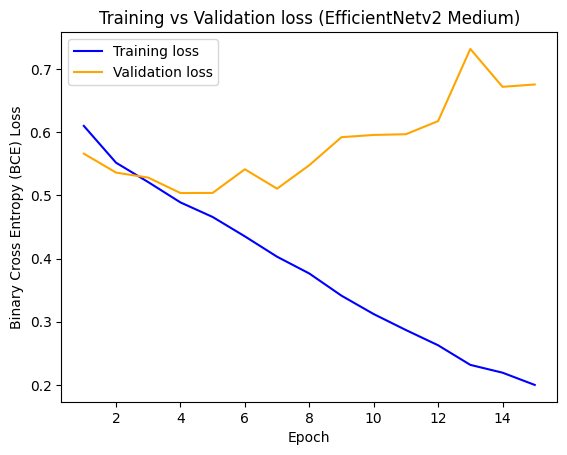

In [11]:
# Plot training and validation loss
total_epoch = len(training_loss)
epoch = list(range(1, total_epoch+1))

# Plot the training loss
plt.plot(epoch, training_loss, label='Training loss', color='blue')  # Red line

# Plot the validation loss
plt.plot(epoch, validation_loss, label='Validation loss', color='orange')  # Green line

# Adding labels
plt.xlabel('Epoch')
plt.ylabel('Binary Cross Entropy (BCE) Loss')
plt.title('Training vs Validation loss (EfficientNetv2 Medium)')

# Show legend
plt.legend()

# Save the plot
plt.savefig("/kaggle/working/train_val_loss.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


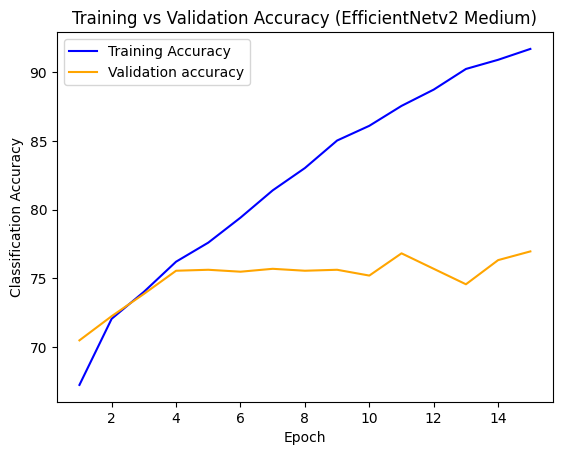

In [12]:
# Plot the training accuracy
plt.plot(epoch, training_accuracy, label='Training Accuracy', color='blue')  # Red line

# Plot the validation accuracy
plt.plot(epoch, validation_accuracy, label='Validation accuracy', color='orange')  # Green line


# Adding labels
plt.xlabel('Epoch')
plt.ylabel('Classification Accuracy')
plt.title('Training vs Validation Accuracy (EfficientNetv2 Medium)')

# Show legend
plt.legend()

# Save the plot
plt.savefig("/kaggle/working/train_val_acc.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

In [13]:
# Perform model evaluation on testing data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()  # Set the model to evaluation mode

# Initialize lists to store true labels and predictions
all_labels = []
all_preds = []

# If you're using a loss function (e.g., for binary classification)
criterion = torch.nn.BCEWithLogitsLoss()  # Example for binary classification, modify if needed

# Iterate over the test dataloader
with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)  # Forward pass
        
        # Calculate loss (if applicable)
        loss = criterion(outputs.squeeze(), labels.float())  # Assuming binary classification
        
        # Convert model outputs to predictions
        preds = (outputs > 0).float()  # Assuming binary classification

        # Collect labels and predictions for metrics calculation
        all_labels.extend(labels.cpu().numpy())  # Convert to numpy for sklearn
        all_preds.extend(preds.squeeze().cpu().numpy())  # Convert to numpy for sklearn

# Calculate Accuracy
accuracy = accuracy_score(all_labels, all_preds)

# Calculate Precision, Recall, and F1-Score
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Accuracy: 0.7556
Precision: 0.7688
Recall: 0.7321
F1-Score: 0.7500


In [14]:
# Delete the dataset and Save the model
!rm -rf AFAD-Full
!rm -rf __pycache__
torch.save(model, 'EfficientNetV2_S.pth')